# Project 1

# Project 2

In [66]:
from assimulo.problem import Implicit_Problem, Explicit_Problem
from assimulo.solvers.sundials import IDA
from assimulo.solvers.runge_kutta import RungeKutta4
import numpy as np
import scipy.optimize as opt

from input_data import (
	m1, m2, m3, m4, m5, m6, m7,
	i1, i2, i3, i4, i5, i6, i7,
	xa, xb, xc, ya, yb, yc,
	d, da, e, ea, rr, ra,
	ss, sa, sb, sc, sd,
	ta, tb, u, ua, ub,
	zf, zt, fa, mom, c0, lo)


class Seven_bar_mechanism(Implicit_Problem):
	"""
	A class which describes the squeezer according to
	Hairer, Vol. II, p. 533 ff, see also formula (7.11)
	"""
	problem_name = 'Woodpecker w/o friction'

	def __init__(self, Newton=False):
		self.Newton = Newton
		self.y0, self.yd0 = self.init_squeezer()
		self.t0 = 0
		self.algvar = np.ones(len(self.y0))

	def reset(self):
		self.y0, self.yd0 = self.init_squeezer()

	def init_squeezer(self):
		y = np.hstack((np.array([
			-0.0617138900142764496358948458001,  # beta
			0.,                                  # theta
			0.455279819163070380255912382449,    # gamma
			0.222668390165885884674473185609,    # phi
			0.487364979543842550225598953530,    # delta
			-0.222668390165885884674473185609,   # Omega
			1.23054744454982119249735015568]),   # epsilon
			np.zeros((7,)), np.array([
				98.5668703962410896057654982170,     # lambda[0]
				-6.12268834425566265503114393122]),   # lambda[1]
			np.zeros((4,))))

		if self.Newton:
			new = opt.fsolve(self.Newton_init, 1e-6 * np.ones(13,), args=y)
			return y, np.hstack((new[:7], np.array([
				14222.4439199541138705911625887,        # betadotdot
				-10666.8329399655854029433719415,       # Thetadotdot
				0., 0., 0., 0., 0.]), new[7:]))
		else:
			return y, np.hstack((np.zeros(7,), np.array([
				14222.4439199541138705911625887,        # betadotdot
				-10666.8329399655854029433719415,       # Thetadotdot
				0., 0., 0., 0., 0.]), np.zeros((6,))))

	def Newton_init(self, x, y):
		# Initial computations and assignments
		beta, theta, gamma, phi, delta, omega, epsilon = y[0:7]
		bep, thp, gap, php, dep, omp, epp = y[7:14]
		sibe, sith, siga, siph, side, siom, siep = np.sin(y[0:7])
		cobe, coth, coga, coph, code, coom, coep = np.cos(y[0:7])
		sibeth, cobeth = np.sin(beta + theta), np.cos(beta + theta)
		siphde, cophde = np.sin(phi + delta), np.cos(phi + delta)
		siomep, coomep = np.sin(omega + epsilon), np.cos(omega + epsilon)

		m = np.zeros((7, 7))
		m[0, 0] = m1 * ra**2 + m2 * (rr**2 - 2 * da * rr * coth + da**2) + i1 + i2
		m[1, 0] = m[0, 1] = m2 * (da**2 - da * rr * coth) + i2
		m[1, 1] = m2 * da**2 + i2
		m[2, 2] = m3 * (sa**2 + sb**2) + i3
		m[3, 3] = m4 * (e - ea)**2 + i4
		m[4, 3] = m[3, 4] = m4 * ((e - ea)**2 + zt * (e - ea) * siph) + i4
		m[4, 4] = m4 * (zt**2 + 2 * zt * (e - ea) * siph + (e - ea)**2) + m5 * (ta**2 + tb**2) + i4 + i5
		m[5, 5] = m6 * (zf - fa)**2 + i6
		m[6, 5] = m[5, 6] = m6 * ((zf - fa)**2 - u * (zf - fa) * siom) + i6
		m[6, 6] = m6 * ((zf - fa)**2 - 2 * u * (zf - fa) * siom + u**2) + m7 * (ua**2 + ub**2) + i6 + i7

		gp = np.zeros((6, 7))
		gp[0, 0] = - rr * sibe + d * sibeth
		gp[0, 1] = d * sibeth
		gp[0, 2] = - ss * coga
		gp[1, 0] = rr * cobe - d * cobeth
		gp[1, 1] = - d * cobeth
		gp[1, 2] = - ss * siga
		gp[2, 0] = - rr * sibe + d * sibeth
		gp[2, 1] = d * sibeth
		gp[2, 3] = - e * cophde
		gp[2, 4] = - e * cophde + zt * side
		gp[3, 0] = rr * cobe - d * cobeth
		gp[3, 1] = - d * cobeth
		gp[3, 3] = - e * siphde
		gp[3, 4] = - e * siphde - zt * code
		gp[4, 0] = - rr * sibe + d * sibeth
		gp[4, 1] = d * sibeth
		gp[4, 5] = zf * siomep
		gp[4, 6] = zf * siomep - u * coep
		gp[5, 0] = rr * cobe - d * cobeth
		gp[5, 1] = - d * cobeth
		gp[5, 5] = - zf * coomep
		gp[5, 6] = - zf * coomep - u * siep

		return np.vstack((np.hstack((m, gp.T)), np.hstack((gp, np.zeros((6, 6)))))) @ x

	def res(self, t, y, yp):
		"""
		Residual function of the 7-bar mechanism in
		Hairer, Vol. II, p. 533 ff, see also formula (7.11)
		written in residual form
		y,yp vector of dim 20, t scalar
		"""

		# Initial computations and assignments
		beta, theta, gamma, phi, delta, omega, epsilon = y[0:7]
		bep, thp, gap, php, dep, omp, epp = y[7:14]
		lamb = y[14:20]
		sibe, sith, siga, siph, side, siom, siep = np.sin(y[0:7])
		cobe, coth, coga, coph, code, coom, coep = np.cos(y[0:7])
		sibeth, cobeth = np.sin(beta + theta), np.cos(beta + theta)
		siphde, cophde = np.sin(phi + delta), np.cos(phi + delta)
		siomep, coomep = np.sin(omega + epsilon), np.cos(omega + epsilon)

		# Mass matrix
		m = np.zeros((7, 7))
		m[0, 0] = m1 * ra**2 + m2 * (rr**2 - 2 * da * rr * coth + da**2) + i1 + i2
		m[1, 0] = m[0, 1] = m2 * (da**2 - da * rr * coth) + i2
		m[1, 1] = m2 * da**2 + i2
		m[2, 2] = m3 * (sa**2 + sb**2) + i3
		m[3, 3] = m4 * (e - ea)**2 + i4
		m[4, 3] = m[3, 4] = m4 * ((e - ea)**2 + zt * (e - ea) * siph) + i4
		m[4, 4] = m4 * (zt**2 + 2 * zt * (e - ea) * siph + (e - ea)**2) + m5 * (ta**2 + tb**2) + i4 + i5
		m[5, 5] = m6 * (zf - fa)**2 + i6
		m[6, 5] = m[5, 6] = m6 * ((zf - fa)**2 - u * (zf - fa) * siom) + i6
		m[6, 6] = m6 * ((zf - fa)**2 - 2 * u * (zf - fa) * siom + u**2) + m7 * (ua**2 + ub**2) + i6 + i7

		# Applied forces
		xd = sd * coga + sc * siga + xb
		yd = sd * siga - sc * coga + yb
		lang = np.sqrt((xd - xc)**2 + (yd - yc)**2)
		force = - c0 * (lang - lo) / lang
		fx = force * (xd - xc)
		fy = force * (yd - yc)
		ff = np.array([
			mom - m2 * da * rr * thp * (thp + 2 * bep) * sith,
			m2 * da * rr * bep**2 * sith,
			fx * (sc * coga - sd * siga) + fy * (sd * coga + sc * siga),
			m4 * zt * (e - ea) * dep**2 * coph,
			- m4 * zt * (e - ea) * php * (php + 2 * dep) * coph,
			- m6 * u * (zf - fa) * epp**2 * coom,
			m6 * u * (zf - fa) * omp * (omp + 2 * epp) * coom])

		# Constraint matrix, G
		gp = np.zeros((6, 7))
		gp[0, 0] = - rr * sibe + d * sibeth
		gp[0, 1] = d * sibeth
		gp[0, 2] = - ss * coga
		gp[1, 0] = rr * cobe - d * cobeth
		gp[1, 1] = - d * cobeth
		gp[1, 2] = - ss * siga
		gp[2, 0] = - rr * sibe + d * sibeth
		gp[2, 1] = d * sibeth
		gp[2, 3] = - e * cophde
		gp[2, 4] = - e * cophde + zt * side
		gp[3, 0] = rr * cobe - d * cobeth
		gp[3, 1] = - d * cobeth
		gp[3, 3] = - e * siphde
		gp[3, 4] = - e * siphde - zt * code
		gp[4, 0] = - rr * sibe + d * sibeth
		gp[4, 1] = d * sibeth
		gp[4, 5] = zf * siomep
		gp[4, 6] = zf * siomep - u * coep
		gp[5, 0] = rr * cobe - d * cobeth
		gp[5, 1] = - d * cobeth
		gp[5, 5] = - zf * coomep
		gp[5, 6] = - zf * coomep - u * siep

		# Construction of the residual
		if self.index == 3:  # Index-3 constraint
			res_3 = np.array([
				rr * cobe - d * cobeth - ss * siga - xb,
				rr * sibe - d * sibeth + ss * coga - yb,
				rr * cobe - d * cobeth - e * siphde - zt * code - xa,
				rr * sibe - d * sibeth + e * cophde - zt * side - ya,
				rr * cobe - d * cobeth - zf * coomep - u * siep - xa,
				rr * sibe - d * sibeth - zf * siomep + u * coep - ya])
		if self.index == 2:  # Index-2 constraint
			res_3 = np.dot(gp, y[7:14])
		if self.index == 1:  # Index-1 constraint
			res_3 = np.array([
				- rr * cobe * bep**2 + d * cobeth * (bep + thp)**2 + ss * siga * gap**2,
				- rr * sibe * bep**2 + d * sibeth * (bep + thp)**2 - ss * coga * gap**2,
				- rr * cobe * bep**2 + d * cobeth * (bep + thp)**2 + e * siphde * (php + dep)**2 + zt * code * dep**2,
				- rr * sibe * bep ** 2 + d * sibeth * (bep + thp)**2 - e * cophde * (php + dep)**2 + zt * side * dep**2,
				- rr * cobe * bep**2 + d * cobeth * (bep + thp)**2 + zf * coomep * (omp + epp)**2 + u * siep * epp**2,
				- rr * sibe * bep**2 + d * sibeth * (bep + thp)**2 + zf * siomep * (omp + epp)**2 - u * coep * epp**2])
			res_3 += np.dot(gp, yp[7:14])

		return np.hstack((yp[0:7] - y[7:14], np.dot(m, yp[7:14]) - ff[0:7] + np.dot(gp.T, lamb), res_3))

	def rhs(self, t, y):
		"""
		Residual function of the 7-bar mechanism in
		Hairer, Vol. II, p. 533 ff, see also formula (7.11)
		written in residual form
		y,yp vector of dim 20, t scalar
		"""

		# Initial computations and assignments
		beta, theta, gamma, phi, delta, omega, epsilon = y[0:7]
		bep, thp, gap, php, dep, omp, epp = y[7:14]
		sibe, sith, siga, siph, side, siom, siep = np.sin(y[0:7])
		cobe, coth, coga, coph, code, coom, coep = np.cos(y[0:7])
		sibeth, cobeth = np.sin(beta + theta), np.cos(beta + theta)
		siphde, cophde = np.sin(phi + delta), np.cos(phi + delta)
		siomep, coomep = np.sin(omega + epsilon), np.cos(omega + epsilon)

		# Mass matrix
		m = np.zeros((7, 7))
		m[0, 0] = m1 * ra**2 + m2 * (rr**2 - 2 * da * rr * coth + da**2) + i1 + i2
		m[1, 0] = m[0, 1] = m2 * (da**2 - da * rr * coth) + i2
		m[1, 1] = m2 * da**2 + i2
		m[2, 2] = m3 * (sa**2 + sb**2) + i3
		m[3, 3] = m4 * (e - ea)**2 + i4
		m[4, 3] = m[3, 4] = m4 * ((e - ea)**2 + zt * (e - ea) * siph) + i4
		m[4, 4] = m4 * (zt**2 + 2 * zt * (e - ea) * siph + (e - ea)**2) + m5 * (ta**2 + tb**2) + i4 + i5
		m[5, 5] = m6 * (zf - fa)**2 + i6
		m[6, 5] = m[5, 6] = m6 * ((zf - fa)**2 - u * (zf - fa) * siom) + i6
		m[6, 6] = m6 * ((zf - fa)**2 - 2 * u * (zf - fa) * siom + u**2) + m7 * (ua**2 + ub**2) + i6 + i7

		# Applied forces
		xd = sd * coga + sc * siga + xb
		yd = sd * siga - sc * coga + yb
		lang = np.sqrt((xd - xc)**2 + (yd - yc)**2)
		force = - c0 * (lang - lo) / lang
		fx = force * (xd - xc)
		fy = force * (yd - yc)
		ff = np.array([
			mom - m2 * da * rr * thp * (thp + 2 * bep) * sith,
			m2 * da * rr * bep**2 * sith,
			fx * (sc * coga - sd * siga) + fy * (sd * coga + sc * siga),
			m4 * zt * (e - ea) * dep**2 * coph,
			- m4 * zt * (e - ea) * php * (php + 2 * dep) * coph,
			- m6 * u * (zf - fa) * epp**2 * coom,
			m6 * u * (zf - fa) * omp * (omp + 2 * epp) * coom])

		# Constraint matrix, G
		gp = np.zeros((6, 7))
		gp[0, 0] = - rr * sibe + d * sibeth
		gp[0, 1] = d * sibeth
		gp[0, 2] = - ss * coga
		gp[1, 0] = rr * cobe - d * cobeth
		gp[1, 1] = - d * cobeth
		gp[1, 2] = - ss * siga
		gp[2, 0] = - rr * sibe + d * sibeth
		gp[2, 1] = d * sibeth
		gp[2, 3] = - e * cophde
		gp[2, 4] = - e * cophde + zt * side
		gp[3, 0] = rr * cobe - d * cobeth
		gp[3, 1] = - d * cobeth
		gp[3, 3] = - e * siphde
		gp[3, 4] = - e * siphde - zt * code
		gp[4, 0] = - rr * sibe + d * sibeth
		gp[4, 1] = d * sibeth
		gp[4, 5] = zf * siomep
		gp[4, 6] = zf * siomep - u * coep
		gp[5, 0] = rr * cobe - d * cobeth
		gp[5, 1] = - d * cobeth
		gp[5, 5] = - zf * coomep
		gp[5, 6] = - zf * coomep - u * siep

		gqq = np.array([
			- rr * cobe * bep**2 + d * cobeth * (bep + thp)**2 + ss * siga * gap**2,
			- rr * sibe * bep**2 + d * sibeth * (bep + thp)**2 - ss * coga * gap**2,
			- rr * cobe * bep**2 + d * cobeth * (bep + thp)**2 + e * siphde * (php + dep)**2 + zt * code * dep**2,
			- rr * sibe * bep ** 2 + d * sibeth * (bep + thp)**2 - e * cophde * (php + dep)**2 + zt * side * dep**2,
			- rr * cobe * bep**2 + d * cobeth * (bep + thp)**2 + zf * coomep * (omp + epp)**2 + u * siep * epp**2,
			- rr * sibe * bep**2 + d * sibeth * (bep + thp)**2 + zf * siomep * (omp + epp)**2 - u * coep * epp**2])

		res_2 = np.linalg.solve(np.vstack((np.hstack((m, gp.T)), np.hstack((gp, np.zeros((6, 6)))))), np.hstack((ff, -gqq)))

		return np.hstack((y[7:14], res_2))

In [67]:
class Seven_bar_mechanism_index3(Seven_bar_mechanism):
	def __init__(self):
		Seven_bar_mechanism.__init__(self)
		self.algvar[7:] = np.zeros(13)
		self.index = 3


class Seven_bar_mechanism_index2(Seven_bar_mechanism):
	def __init__(self):
		Seven_bar_mechanism.__init__(self)
		self.algvar[14:] = np.zeros(6)
		self.index = 2


class Seven_bar_mechanism_index1(Seven_bar_mechanism):
	def __init__(self):
		Seven_bar_mechanism.__init__(self, Newton=True)
		self.index = 1


class Seven_bar_mechanism_exp(Explicit_Problem):
	def __init__(self):
		Seven_bar_mechanism.__init__(self)

	def init_squeezer(self):
		return Seven_bar_mechanism.init_squeezer(self)

	def Newton_init(self, x, y):
		return Seven_bar_mechanism.Newton_init(self, x, y)

	def rhs(self, t, y):
		return Seven_bar_mechanism.rhs(self, t, y)

In [68]:
if __name__ == "__main__":
	import matplotlib.pyplot as plt

	def plotProject2(t, y, plottitle):
		plotlabels1 = ["$\\beta$", "$\\Theta$", "$\\gamma$", "$\\Phi$", "$\\delta$", "$\\Omega$", "$\\epsilon$"]
		plotlabels2 = ["$\\dot{\\beta}$", "$\\dot{\\Theta}$", "$\\dot{\\gamma}$", "$\\dot{\\Phi}$", "$\\dot{\\delta}$", "$\\dot{\\Omega}$", "$\\dot{\\epsilon}$"]
		plotlabels3 = ["$\\lambda_1$", "$\\lambda_2$", "$\\lambda_3$", "$\\lambda_4$", "$\\lambda_5$", "$\\lambda_6$"]

		plt.plot(t, np.fmod(y[:, 0:7], 2 * np.pi), label=plotlabels1)
		plt.ylim(-2, 2)
		plt.title(plottitle)
		plt.grid()
		plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)
		plt.show()

		plt.plot(t, y[:, 7:14], label=plotlabels2)
		plt.title(plottitle)
		plt.grid()
		plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)
		plt.show()

		plt.plot(t, y[:, 14:], label=plotlabels3)
		plt.title(plottitle)
		plt.grid()
		plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)
		plt.show()

Final Run Statistics: --- 

 Number of steps                                 : 791
 Number of function evaluations                  : 1766
 Number of Jacobian evaluations                  : 733
 Number of function eval. due to Jacobian eval.  : 1766
 Number of error test failures                   : 11
 Number of nonlinear iterations                  : 1766
 Number of nonlinear convergence failures        : 263

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : [1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e+05 1.e+05 1.e+05
 1.e+05 1.e+05 1.e+05 1.e+05 1.e+05 1.e+05 1.e+05 1.e+05 1.e+05 1.e+05]
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 0.03 seconds.
Elapsed simulation time: 1.936799069000699 seconds.


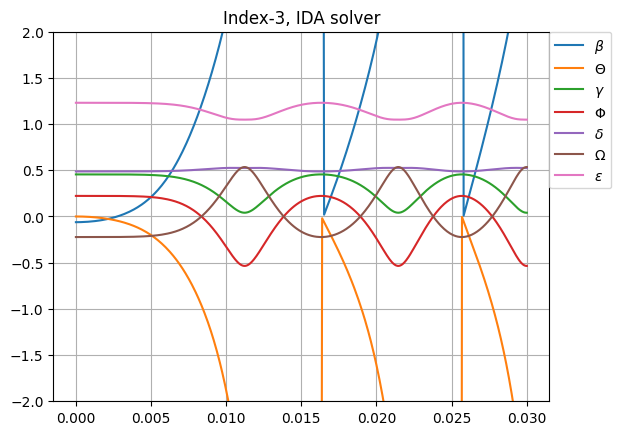

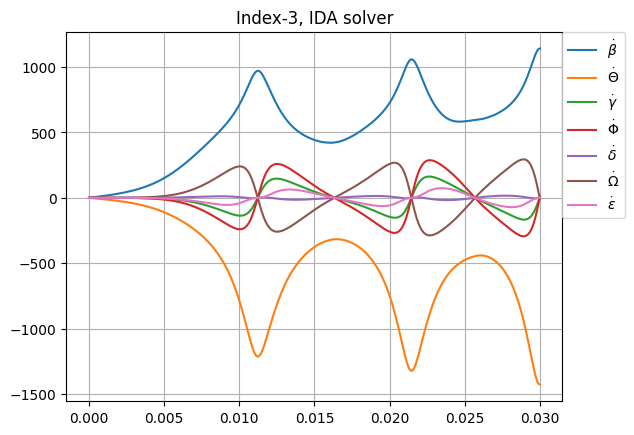

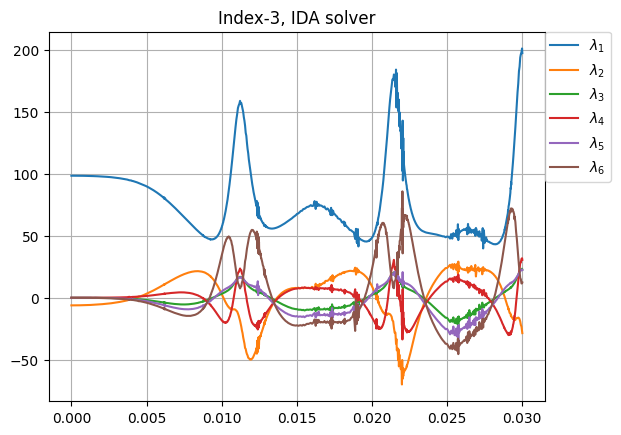

In [69]:
problem = Seven_bar_mechanism_index3()
solver = IDA(problem)
tol3 = 1.e-6 * np.ones(20)
tol3[7:] = 1.e5 * np.ones(13)
solver.atol = tol3
t, y, _ = solver.simulate(0.03)
plotProject2(t, y, "Index-3, IDA solver")

Final Run Statistics: --- 

 Number of steps                                 : 1039
 Number of function evaluations                  : 1729
 Number of Jacobian evaluations                  : 104
 Number of function eval. due to Jacobian eval.  : 1729
 Number of error test failures                   : 47
 Number of nonlinear iterations                  : 1729
 Number of nonlinear convergence failures        : 10

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : [1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06
 1.e-06 1.e-06 1.e-06 1.e-06 1.e+05 1.e+05 1.e+05 1.e+05 1.e+05 1.e+05]
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 0.03 seconds.
Elapsed simulation time: 0.5199372110000695 seconds.


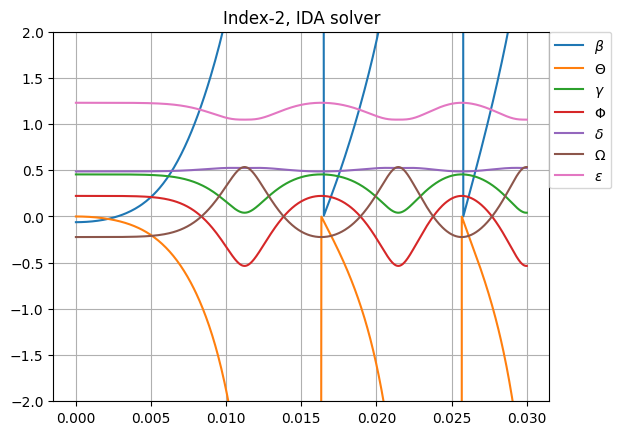

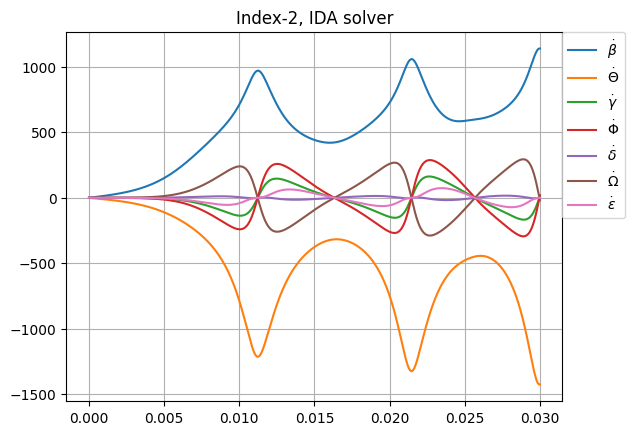

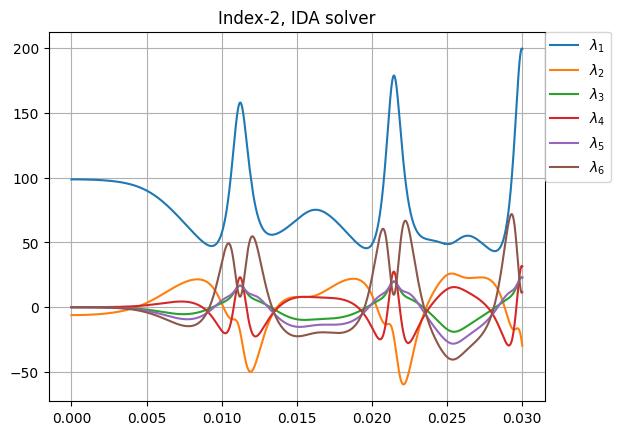

In [70]:
problem = Seven_bar_mechanism_index2()
solver = IDA(problem)
tol2 = 1.e-6 * np.ones(20)
tol2[14:] = 1.e5 * np.ones(6)
solver.atol = tol2
t, y, _ = solver.simulate(0.03)
plotProject2(t, y, "Index-2, IDA solver")

Final Run Statistics: --- 

 Number of steps                                 : 1668
 Number of function evaluations                  : 2555
 Number of Jacobian evaluations                  : 154
 Number of function eval. due to Jacobian eval.  : 2555
 Number of error test failures                   : 70
 Number of nonlinear iterations                  : 2555
 Number of nonlinear convergence failures        : 37

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 0.03 seconds.
Elapsed simulation time: 0.9347845650045201 seconds.


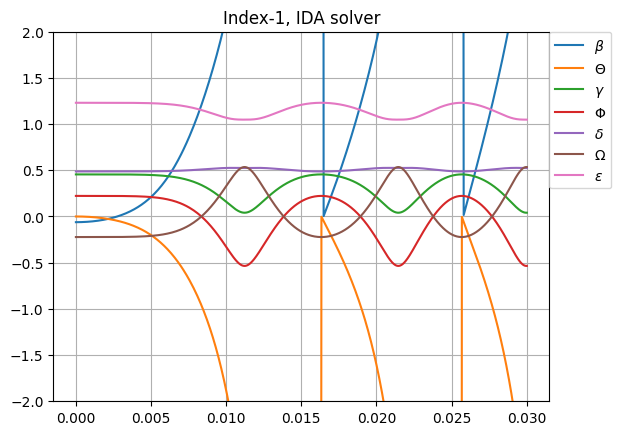

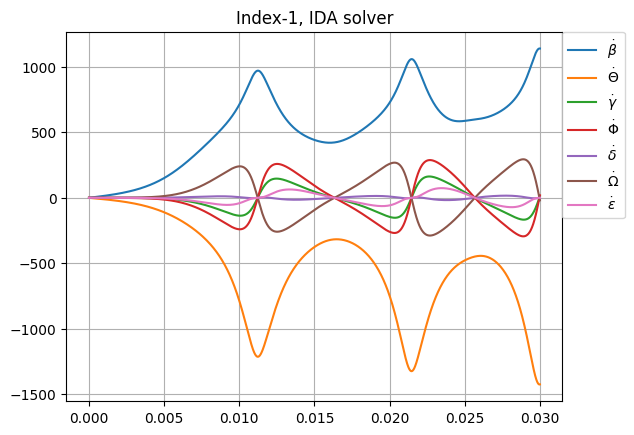

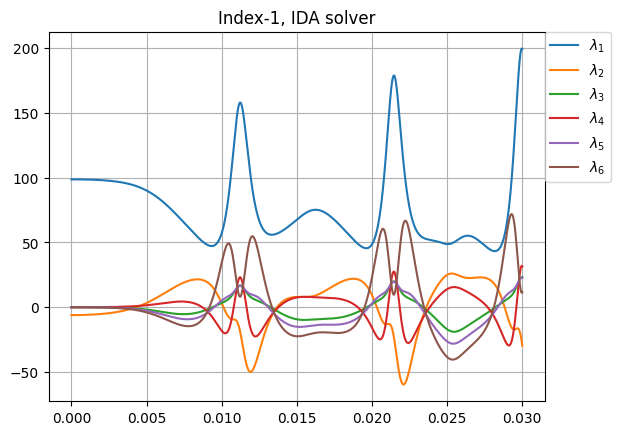

In [71]:
problem = Seven_bar_mechanism_index1()
solver = IDA(problem)
tol1 = 1.e-6 * np.ones(20)
solver.atol = tol1
t, y, _ = solver.simulate(0.03)
plotProject2(t, y, "Index-1, IDA solver")

Final Run Statistics: --- 

 Step-length          : 0.0001 

Solver options:

 Solver            : RungeKutta4
 Solver type       : Fixed step

Simulation interval    : 0.0 - 0.03 seconds.
Elapsed simulation time: 0.36836339499859605 seconds.


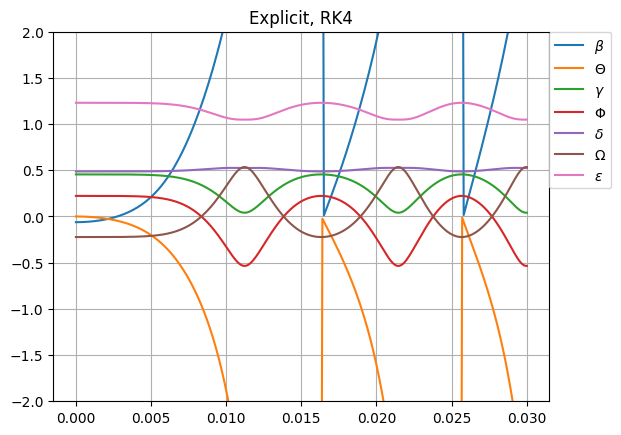

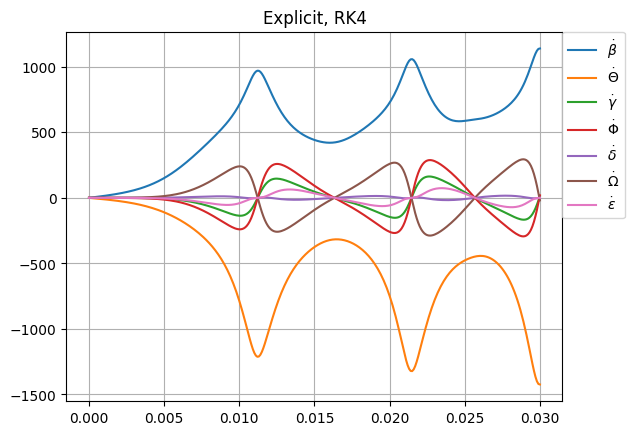

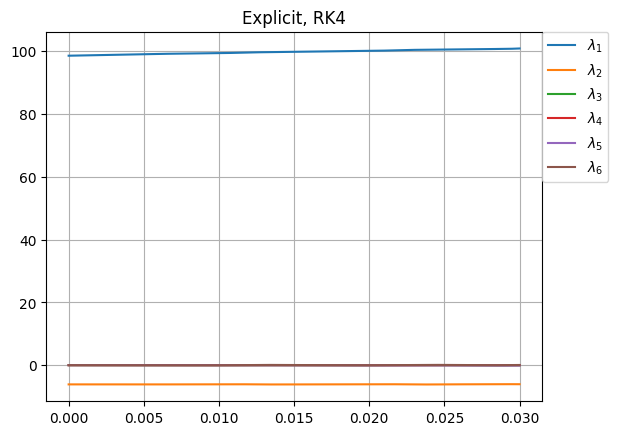

In [72]:
problem = Seven_bar_mechanism_exp()
solver = RungeKutta4(problem)
solver._set_h(0.0001)
t, y = solver.simulate(0.03)
plotProject2(t, y, "Explicit, RK4")

# Project 3

In [73]:
from assimulo.ode import Explicit_Problem, Explicit_ODE_Exception, ID_PY_OK
from assimulo.explicit_ode import Explicit_ODE
import numpy as np
import scipy as sp


class Explicit_Problem_2nd(Explicit_Problem):
    def __init__(self, y0, Mmat, Cmat, Kmat, func):
        self.t0 = 0
        self.y0 = y0

        self.Mmat = Mmat
        self.Cmat = Cmat
        self.Kmat = Kmat
        self.func = func

    def rhs(self, t, y):
        up = y[len(y) // 2:]
        return np.hstack((up,
                          sp.sparse.linalg.spsolve(self.Mmat,
                                                   self.Kmat @ y[:len(y) // 2] + self.Cmat @ up + self.func(t))))

In [74]:
class Explicit_2nd_Order(Explicit_ODE):
    tol = 1.e-8
    maxit = 100
    maxsteps = 5000

    def __init__(self, problem):
        Explicit_ODE.__init__(self, problem)

        self.options["h"] = 0.01
        self.statistics["nsteps"] = 0
        self.statistics["nfcns"] = 0

    def _get_h(self):
        return self.options["h"]

    def _set_h(self, new_h):
        self.options["h"] = float(new_h)

    def integrate(self, t, y, tf, opts):
        h = min([self._get_h(), abs(tf - t)])
        u, up, upp = self.step_zero(t, y, h)
        self.statistics["nfcns"] += 1
        y_list = [y]
        t_list = [t]
        for i in range(self.maxsteps):
            t = t + h
            if t >= tf:
                h = tf - t_list[-1]
                u, up, upp = self.last_step(u, up, upp, h, tf)
                self.statistics["nsteps"] += 1
                t_list.append(t)
                y_list.append(np.hstack((u, up)))
                break
            u, up, upp = self.step(u, up, upp, h, t)
            self.statistics["nsteps"] += 1
            t_list.append(t)
            y_list.append(np.hstack((u, up)))
            h = self._get_h()
        else:
            raise Explicit_ODE_Exception('Final time not reached within maximum number of steps')

        return ID_PY_OK, t_list, y_list

    def step_zero(self, t, y, h):
        u = y[:len(y) // 2]
        up = y[len(y) // 2:]
        upp = self.problem.rhs(t, y)[len(y) // 2:]
        return u, up, upp

    def last_step(self, u, up, upp, h, t):
        return self.step(u, up, upp, h, t)

In [75]:
class Newmark_Exp(Explicit_2nd_Order):
    def __init__(self, problem, gamma=0.5):
        Explicit_2nd_Order.__init__(self, problem)
        self.gamma = gamma

    def step(self, u, up, upp, h, t):
        u_np1 = u + up * h + 0.5 * upp * h**2
        upp_np1 = self.problem.rhs(t, np.hstack((u, np.zeros(len(up)))))[len(upp):]
        self.statistics["nfcns"] += 1
        up_np1 = up + upp * h * (1 - self.gamma) + upp_np1 * self.gamma * h
        return u_np1, up_np1, upp_np1

Final Run Statistics: Explicit Newmark solver 

 Number of steps                 : 301
 Number of function evaluations  : 302
Simulation interval    : 0.0 - 3.00999999999998 seconds.
Elapsed simulation time: 0.036191995997796766 seconds.


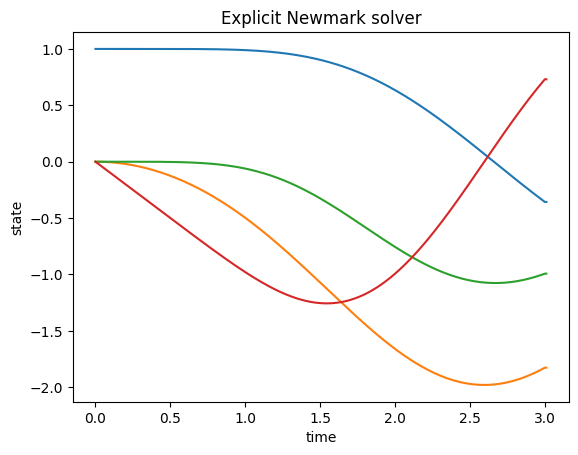

In [76]:
def problem_func(t, y):
    temp = spring_constant * (1 - 1 / np.sqrt(y[0]**2 + y[1]**2))
    return np.asarray([y[2], y[3], -y[0] * temp, -y[1] * temp - 1])
spring_constant = 3

starting_point = np.array([1 - 1e-6, 0, 0, 0])
problem = Explicit_Problem(problem_func, y0=starting_point)
t_end = 3

problem.name = "Explicit Newmark solver"
solver = Newmark_Exp(problem)
t, y = solver.simulate(t_end)
solver.plot()

In [77]:
class HHT(Explicit_2nd_Order):
    def __init__(self, problem, alpha=0):
        Explicit_2nd_Order.__init__(self, problem)

        self.alpha = alpha
        self.beta = ((1 - alpha) / 2)**2
        self.gamma = 0.5 - alpha
        self.gdb = self.gamma / self.beta

        self.Mmat = self.problem.Mmat
        self.Cmat = self.problem.Cmat
        self.Kmat = self.problem.Kmat
        self.func = self.problem.func

    def step_zero(self, t, y, h):
        self.Amat = self.Mmat / (self.beta * h**2) + self.Cmat * (self.gdb / h) + self.Kmat * (1 + self.alpha)
        return Explicit_2nd_Order.step_zero(self, t, y, h)

    def step(self, u, up, upp, h, t):
        temp = self.Mmat @ (u / (self.beta * h**2) + up / (self.beta * h) + upp * (1 / (2 * self.beta) - 1))
        temp += self.Cmat @ (u * (self.gdb / h) - up * (1 - self.gdb) - upp * h * (1 - self.gdb / 2))
        temp += self.alpha * self.Kmat @ u
        u_np1 = sp.sparse.linalg.spsolve(self.Amat, self.problem.func(t) + temp)
        self.statistics["nfcns"] += 1
        up_np1 = ((u_np1 - u) / h) * self.gdb + up * (1 - self.gdb) + upp * h * (1 - self.gdb / 2)
        upp_np1 = (u_np1 - u) / (self.beta * h**2) - up / (self.beta * h) - upp * (1 / (2 * self.beta) - 1)
        return u_np1, up_np1, upp_np1

    def last_step(self, u, up, upp, h, t):
        self.Amat = self.Mmat / (self.beta * h**2) + self.Cmat * (self.gdb / h) + self.Kmat * (1 + self.alpha)
        return self.step(u, up, upp, h, t)

In [78]:
class Newmark(HHT):
    def __init__(self, problem, beta=0.5, gamma=0.5):
        HHT.__init__(self, problem, alpha=0)
        self.beta = beta
        self.gamma = gamma
        self.gdb = self.gamma / self.beta

        if not (0.5 <= gamma <= 2 * beta):
            print("Method is not unconditionally stable.")
        if (gamma == 2 * beta == 0.5):
            print("Method is second order accurate.")
        else:
            print("Method is first order accurate.")

In [84]:
import matplotlib.pyplot as pl
import numpy as np
import scipy.sparse.linalg as ssl

from ufl import as_vector, conditional, ds, dx, Identity, inner
from ufl import nabla_div, nabla_grad, SpatialCoordinate, TestFunction, TrialFunction
from dune.ufl import Constant, DirichletBC
from dune.grid import structuredGrid as leafGridView
from dune.fem.space import lagrange as lagrangeSpace

from dune.fem.operator import galerkin as galerkinOperator
from dune.fem.operator import linear as linearOperator


import os
# ensure some compilation output for this example
os.environ['DUNE_LOG_LEVEL'] = 'info'
print("Using DUNE_LOG_LEVEL=", os.getenv('DUNE_LOG_LEVEL'))
pl.close('all')


class elastodynamic_beam:
    # Elastic parameters
    E = 1000.0
    nu = 0.3
    mu = Constant(E / (2. * (1. + nu)), name="mu")
    lmbda = Constant(E * nu / ((1. + nu) * (1. - 2. * nu)), name="lmbda")

    # Mass density
    rho = Constant(1., name="rho")

    # Rayleigh damping coefficients
    eta_m = Constant(0., name="eta_m")
    eta_k = Constant(0., name="eta_k")

    def __init__(self, gridsize, T=4., dimgrid=2):

        lower, upper, cells = [0., 0.], [1., 0.1], [12 * gridsize, 2 * gridsize]
        if dimgrid == 3:
            lower.append(0)
            upper.append(0.04)
            cells.append(gridsize)

        self.mesh = leafGridView(lower, upper, cells)
        dim = self.mesh.dimension

        # force only up to a certain time
        self.p0 = 1.
        self.cutoff_Tc = T / 5
        # Define the loading as an expression
        self.p = self.p0 / self.cutoff_Tc

        # Define function space for displacement (velocity and acceleration)
        self.V = lagrangeSpace(self.mesh, dimRange=dim, order=1)

        # UFL representative for x-coordinate
        x = SpatialCoordinate(self.V)

        self.bc = DirichletBC(self.V, as_vector(dim * [0]), x[0] < 1e-10)

        # Stress tensor
        def epsilon(r):  # this is exactly dol.sym
            return 0.5 * (nabla_grad(r) + nabla_grad(r).T)

        def sigma(r):
            return nabla_div(r) * Identity(dim) + 2. * self.mu * epsilon(r)

        # trial and test functions
        u = TrialFunction(self.V)
        v = TestFunction(self.V)

        # Mass form
        self.Mass_form = self.rho * inner(u, v) * dx

        # Elastic stiffness form
        self.Stiffness_form = inner(sigma(u), epsilon(v)) * dx
        # Rayleigh damping form
        self.Dampening_form = self.eta_m * self.Mass_form + self.eta_k * self.Stiffness_form

        self.M_FE = galerkinOperator([self.Mass_form, self.bc])       # mass matrix
        self.K_FE = galerkinOperator([self.Stiffness_form, self.bc])  # stiffness matrix
        self.D_FE = galerkinOperator([self.Dampening_form, self.bc])  # damping matrix

        # linear operator to assemble system matrices
        self.Mass_mat = linearOperator(self.M_FE).as_numpy.tocsc()
        self.Stiffness_mat = linearOperator(self.K_FE).as_numpy.tocsc()
        self.Dampening_mat = linearOperator(self.D_FE).as_numpy.tocsc()

        # Work of external forces
        # dimvec = dim * [0]
        pvec = dim * [0]
        pvec[1] = conditional(x[0] < 1 - 1e-10, 1, 0) * self.p * 0.1
        pvec = as_vector(pvec)

        # right hand side
        self.External_forces_form = (inner(u, v) - inner(u, v)) * dx + inner(v, pvec) * ds
        self.F_ext = galerkinOperator(self.External_forces_form)

        self.ndofs = self.V.size
        self.F = np.zeros(self.V.size)
        self.fh = self.V.interpolate(dim * [0], name="fh")
        self.rh = self.V.interpolate(dim * [0], name="rh")
        self.F_ext(self.fh, self.rh)

        rh_np = self.rh.as_numpy
        self.F[:] = rh_np[:]

        print('degrees of freedom: ', self.ndofs)

    def func(self, t):
        Ft = t * self.F if t < self.cutoff_Tc else np.zeros(self.ndofs)
        return Ft

    def res(self, t, y, yp, ypp):
        if t < self.cutoff_Tc:
            return self.Mass_mat @ ypp * self.Stiffness_mat @ yp + self.Dampening_mat @ y - t * self.F
        else:
            return self.Mass_mat @ ypp * self.Stiffness_mat @ yp + self.Dampening_mat @ y

    def rhs(self, t, y):
        Ft = self.func(t)
        return np.hstack((y[self.ndofs:],
                          ssl.spsolve(self.Mass_mat,
                                      Ft - self.Stiffness_mat @ y[:self.ndofs] - self.Dampening_mat @ y[self.ndofs:])))

    def evaluateAt(self, y, position):
        # from dune.common import FieldVector
        from dune.fem.utility import pointSample
        # from dune.generator import algorithm

        # convert vector back to DUNE function that can be sampled on the mesh
        y1 = np.array(y[:self.ndofs])
        df_y = self.V.function("df_y1", dofVector=y1)

        if len(position) < self.mesh.dimension:
            position.append(0)

        val = pointSample(df_y, position)
        return val[1]  # return displacement in y-direction

    def plotBeam(self, y):
        # convert vector back to DUNE function
        y1 = np.array(y[:self.ndofs])
        displacement = self.V.function("displacement", dofVector=y1)
        from dune.fem.view import geometryGridView
        x = SpatialCoordinate(self.V)
        # interpolate into coordinates for geometryGridView
        position = self.V.interpolate(x + displacement, name="position")
        beam = geometryGridView(position)
        beam.plot()

Using DUNE_LOG_LEVEL= info


In [90]:
t_end = 8
beam_class = elastodynamic_beam(4, T=t_end)

def make_simulation(beam, plot=False):
    beam._set_h(0.05)  # constant step size here
    tt, y = beam.simulate(t_end)

    disp_tip = []
    plottime = 0
    plotstep = 0.25
    for i, t in enumerate(tt):
        disp_tip.append(beam_class.evaluateAt(y[i], [1, 0.05]))
        if t > plottime:
            if plot:
                print(f"Beam position at t={t}")
                beam_class.plotBeam(y[i])
            plottime += plotstep
    return tt, disp_tip

degrees of freedom:  882


Method is first order accurate.
Final Run Statistics: Modified Elastodyn example from DUNE-FEM. Solved using Newmark. 

 Number of steps                 : 161
 Number of function evaluations  : 162
Simulation interval    : 0.0 - 8.04999999999998 seconds.
Elapsed simulation time: 4.783606285003771 seconds.


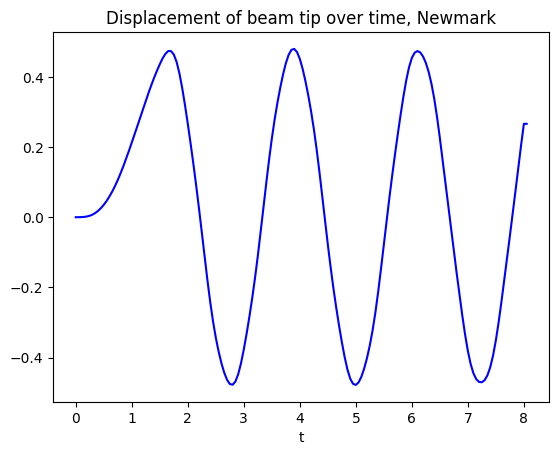

In [93]:
beam_problem2 = Explicit_Problem_2nd(y0=np.zeros((2 * beam_class.ndofs,)),
                                             Mmat=beam_class.Mass_mat,
                                             Cmat=beam_class.Dampening_mat,
                                             Kmat=beam_class.Stiffness_mat,
                                             func=beam_class.func)

beam_problem2.name = 'Modified Elastodyn example from DUNE-FEM. Solved using Newmark.'
beamNew = Newmark(beam_problem2, beta=0.25, gamma=0.5)  # Newmark solver instance
tt, disp_tip = make_simulation(beamNew, False)
pl.figure()
pl.plot(tt, disp_tip, '-b')
pl.title('Displacement of beam tip over time, Newmark')
pl.xlabel('t')
pl.savefig('displacement_Newmark.png', dpi=200)

Final Run Statistics: Modified Elastodyn example from DUNE-FEM. Solved using HHT. 

 Number of steps                 : 161
 Number of function evaluations  : 162
Simulation interval    : 0.0 - 8.04999999999998 seconds.
Elapsed simulation time: 3.1325499650047277 seconds.


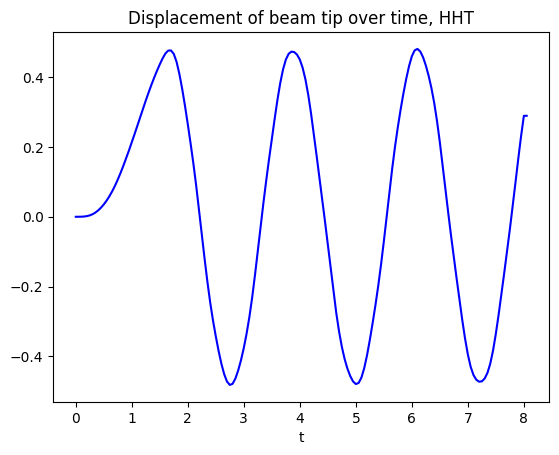

In [94]:
beam_problem2 = Explicit_Problem_2nd(y0=np.zeros((2 * beam_class.ndofs,)),
                                             Mmat=beam_class.Mass_mat,
                                             Cmat=beam_class.Dampening_mat,
                                             Kmat=beam_class.Stiffness_mat,
                                             func=beam_class.func)

beam_problem2.name = 'Modified Elastodyn example from DUNE-FEM. Solved using HHT.'
beamHHT = HHT(beam_problem2, alpha=-1e-2)  # HHT solver instance
tt, disp_tip = make_simulation(beamHHT, False)
pl.figure()
pl.plot(tt, disp_tip, '-b')
pl.title('Displacement of beam tip over time, HHT')
pl.xlabel('t')
pl.savefig('displacement_HHT.png', dpi=200)